## Installation


In [ ]:
!pip install tensorflow==2.7.0

In [ ]:
!pip install "opencv-python-headless<4.3"
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

In [ ]:
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d0_coco17_tpu-32.tar.gz
!tar -xf /content/efficientdet_d0_coco17_tpu-32.tar.gz

In [ ]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

In [ ]:
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

## Imports

In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from object_detection import model_lib_v2
from object_detection import exporter_lib_v2
from object_detection.protos import pipeline_pb2

import cv2

from google.protobuf import text_format
from google.colab import drive

from utils import write_config

drive.mount('/content/drive')

Mounted at /content/drive


## Configuring training


In [7]:
batch_size = 4
num_steps = 6000
num_eval_steps = 1000

train_record_path = '/content/drive/MyDrive/Data/uno/train/Card-Types.tfrecord'
test_record_path = '/content/drive/MyDrive/Data/uno/test/Card-Types.tfrecord'
labelmap_path = '/content/drive/MyDrive/Data/uno/train/Card-Types_label_map.pbtxt'


In [8]:
fine_tune_checkpoint = '/content/efficientdet_d0_coco17_tpu-32/checkpoint/ckpt-0'
base_config_path = '/content/models/research/object_detection/configs/tf2/ssd_efficientdet_d0_512x512_coco17_tpu-8.config'

In [9]:
#Path to saved model
saved_model = '/content/drive/MyDrive/eff_det-d0_train_3_aug_adam'

train_model = False
#Where to save model if you want to train new model
model_dir = '/content/drive/MyDrive/model_path'

In [10]:
write_config(base_config_path,labelmap_path,train_record_path,test_record_path,fine_tune_checkpoint,batch_size,num_steps)

In [11]:
pipeline_config_path = 'model_config.config'

In [12]:
def read_label_map(label_map_path):

    item_id = None
    item_name = None
    items = {}

    with open(label_map_path, "r") as file:
        for line in file:
            line.replace(" ", "")
            if line == "item{":
                pass
            elif line == "}":
                pass
            elif "id" in line:
                item_id = int(line.split(":", 1)[1].strip()[:-1])
            elif "display_name" in line:
                item_name = line.split(" ")[-1].replace("\"", " ").strip()
            if item_id is not None and item_name is not None:
                items[item_id] = item_name
                item_id = None
                item_name = None

    return items


label_map = read_label_map(labelmap_path) 

## Train detector

In [13]:
if train_model:
  saved_model = model_dir

  strategy = tf.compat.v2.distribute.MirroredStrategy()

  with strategy.scope():
      model_lib_v2.train_loop(
          pipeline_config_path=pipeline_config_path,
          model_dir=model_dir,
          train_steps=num_steps,
          use_tpu=False,
          checkpoint_every_n=500,
          record_summaries=True)

## Evaluating

In [14]:
model_lib_v2.eval_continuously(
        pipeline_config_path=pipeline_config_path,
        model_dir=saved_model,
        train_steps=1000,
        sample_1_of_n_eval_examples=1,
        sample_1_of_n_eval_on_train_examples=1,
        checkpoint_dir=saved_model,
        wait_interval=300, timeout=360)

[04/26 11:37:08] tensorflow WARNING: Forced number of epochs for all eval validations to be 1.


INFO:tensorflow:Maybe overwriting sample_1_of_n_eval_examples: 1


[04/26 11:37:08] tensorflow INFO: Maybe overwriting sample_1_of_n_eval_examples: 1


INFO:tensorflow:Maybe overwriting use_bfloat16: False


[04/26 11:37:08] tensorflow INFO: Maybe overwriting use_bfloat16: False


INFO:tensorflow:Maybe overwriting train_steps: 1000


[04/26 11:37:08] tensorflow INFO: Maybe overwriting train_steps: 1000


INFO:tensorflow:Maybe overwriting eval_num_epochs: 1


[04/26 11:37:08] tensorflow INFO: Maybe overwriting eval_num_epochs: 1


[04/26 11:37:08] tensorflow WARNING: Expected number of evaluation epochs is 1, but instead encountered `eval_on_train_input_config.num_epochs` = 0. Overwriting `num_epochs` to 1.


INFO:tensorflow:Reading unweighted datasets: ['/content/drive/MyDrive/Data/uno/test/Card-Types.tfrecord']


[04/26 11:37:11] tensorflow INFO: Reading unweighted datasets: ['/content/drive/MyDrive/Data/uno/test/Card-Types.tfrecord']


INFO:tensorflow:Reading record datasets for input file: ['/content/drive/MyDrive/Data/uno/test/Card-Types.tfrecord']


[04/26 11:37:11] tensorflow INFO: Reading record datasets for input file: ['/content/drive/MyDrive/Data/uno/test/Card-Types.tfrecord']


INFO:tensorflow:Number of filenames to read: 1


[04/26 11:37:11] tensorflow INFO: Number of filenames to read: 1


[04/26 11:37:11] tensorflow WARNING: num_readers has been reduced to 1 to match input file shards.


Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.deterministic`.


[04/26 11:37:11] tensorflow WARNING: From /usr/local/lib/python3.7/dist-packages/object_detection/builders/dataset_builder.py:104: parallel_interleave (from tensorflow.python.data.experimental.ops.interleave_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.deterministic`.


Instructions for updating:
Use `tf.data.Dataset.map()


[04/26 11:37:11] tensorflow WARNING: From /usr/local/lib/python3.7/dist-packages/object_detection/builders/dataset_builder.py:236: DatasetV1.map_with_legacy_function (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.Dataset.map()


Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


[04/26 11:37:17] tensorflow WARNING: From /usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: sparse_to_dense (from tensorflow.python.ops.sparse_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


Instructions for updating:
Use `tf.cast` instead.


[04/26 11:37:19] tensorflow WARNING: From /usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.


INFO:tensorflow:Waiting for new checkpoint at /content/drive/MyDrive/eff_det-d0_train_3_aug_adam


[04/26 11:37:23] tensorflow INFO: Waiting for new checkpoint at /content/drive/MyDrive/eff_det-d0_train_3_aug_adam


INFO:tensorflow:Found new checkpoint at /content/drive/MyDrive/eff_det-d0_train_3_aug_adam/ckpt-14


[04/26 11:37:23] tensorflow INFO: Found new checkpoint at /content/drive/MyDrive/eff_det-d0_train_3_aug_adam/ckpt-14
/usr/local/lib/python3.7/dist-packages/keras/backend.py:450: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


Instructions for updating:
Use `tf.cast` instead.


[04/26 11:38:46] tensorflow WARNING: From /usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: to_int64 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.


INFO:tensorflow:Finished eval step 0


[04/26 11:38:46] tensorflow INFO: Finished eval step 0


Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


[04/26 11:38:46] tensorflow WARNING: From /usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:459: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


INFO:tensorflow:Finished eval step 100


[04/26 11:39:34] tensorflow INFO: Finished eval step 100


INFO:tensorflow:Finished eval step 200


[04/26 11:40:16] tensorflow INFO: Finished eval step 200


INFO:tensorflow:Performing evaluation on 896 images.


[04/26 11:40:53] tensorflow INFO: Performing evaluation on 896 images.


creating index...
index created!
INFO:tensorflow:Loading and preparing annotation results...


[04/26 11:40:53] tensorflow INFO: Loading and preparing annotation results...


INFO:tensorflow:DONE (t=0.07s)


[04/26 11:40:53] tensorflow INFO: DONE (t=0.07s)


creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=7.15s).
Accumulating evaluation results...
DONE (t=1.99s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.788
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.984
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.935
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.760
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.809
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.769
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.827
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.827
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.803
 Average Recall     (AR) @[ IoU=0.5

[04/26 11:41:02] tensorflow INFO: Eval metrics at step 12000


INFO:tensorflow:	+ DetectionBoxes_Precision/mAP: 0.788001


[04/26 11:41:03] tensorflow INFO: 	+ DetectionBoxes_Precision/mAP: 0.788001


INFO:tensorflow:	+ DetectionBoxes_Precision/mAP@.50IOU: 0.984315


[04/26 11:41:03] tensorflow INFO: 	+ DetectionBoxes_Precision/mAP@.50IOU: 0.984315


INFO:tensorflow:	+ DetectionBoxes_Precision/mAP@.75IOU: 0.934805


[04/26 11:41:03] tensorflow INFO: 	+ DetectionBoxes_Precision/mAP@.75IOU: 0.934805


INFO:tensorflow:	+ DetectionBoxes_Precision/mAP (small): 0.760209


[04/26 11:41:03] tensorflow INFO: 	+ DetectionBoxes_Precision/mAP (small): 0.760209


INFO:tensorflow:	+ DetectionBoxes_Precision/mAP (medium): 0.809491


[04/26 11:41:03] tensorflow INFO: 	+ DetectionBoxes_Precision/mAP (medium): 0.809491


INFO:tensorflow:	+ DetectionBoxes_Precision/mAP (large): -1.000000


[04/26 11:41:03] tensorflow INFO: 	+ DetectionBoxes_Precision/mAP (large): -1.000000


INFO:tensorflow:	+ DetectionBoxes_Recall/AR@1: 0.768852


[04/26 11:41:03] tensorflow INFO: 	+ DetectionBoxes_Recall/AR@1: 0.768852


INFO:tensorflow:	+ DetectionBoxes_Recall/AR@10: 0.827130


[04/26 11:41:03] tensorflow INFO: 	+ DetectionBoxes_Recall/AR@10: 0.827130


INFO:tensorflow:	+ DetectionBoxes_Recall/AR@100: 0.827130


[04/26 11:41:03] tensorflow INFO: 	+ DetectionBoxes_Recall/AR@100: 0.827130


INFO:tensorflow:	+ DetectionBoxes_Recall/AR@100 (small): 0.803067


[04/26 11:41:03] tensorflow INFO: 	+ DetectionBoxes_Recall/AR@100 (small): 0.803067


INFO:tensorflow:	+ DetectionBoxes_Recall/AR@100 (medium): 0.877856


[04/26 11:41:03] tensorflow INFO: 	+ DetectionBoxes_Recall/AR@100 (medium): 0.877856


INFO:tensorflow:	+ DetectionBoxes_Recall/AR@100 (large): -1.000000


[04/26 11:41:03] tensorflow INFO: 	+ DetectionBoxes_Recall/AR@100 (large): -1.000000


INFO:tensorflow:	+ Loss/localization_loss: 0.032056


[04/26 11:41:03] tensorflow INFO: 	+ Loss/localization_loss: 0.032056


INFO:tensorflow:	+ Loss/classification_loss: 0.137145


[04/26 11:41:03] tensorflow INFO: 	+ Loss/classification_loss: 0.137145


INFO:tensorflow:	+ Loss/regularization_loss: 0.052297


[04/26 11:41:03] tensorflow INFO: 	+ Loss/regularization_loss: 0.052297


INFO:tensorflow:	+ Loss/total_loss: 0.221499


[04/26 11:41:03] tensorflow INFO: 	+ Loss/total_loss: 0.221499


INFO:tensorflow:Waiting for new checkpoint at /content/drive/MyDrive/eff_det-d0_train_3_aug_adam


[04/26 11:42:23] tensorflow INFO: Waiting for new checkpoint at /content/drive/MyDrive/eff_det-d0_train_3_aug_adam


INFO:tensorflow:Timed-out waiting for a checkpoint.


[04/26 11:48:23] tensorflow INFO: Timed-out waiting for a checkpoint.


## Export model inference graph

In [15]:
output_directory = 'inference_graph'

In [16]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(pipeline_config_path, 'r') as f:
  text_format.Merge(f.read(), pipeline_config)
exporter_lib_v2.export_inference_graph(
      'image_tensor', pipeline_config, saved_model,
      output_directory, False)


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))


[04/26 11:48:27] tensorflow WARNING: From /usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:458: calling map_fn_v2 (from tensorflow.python.ops.map_fn) with back_prop=False is deprecated and will be removed in a future version.
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))


[04/26 11:48:54] tensorflow WARNING: Skipping full serialization of Keras layer <object_detection.meta_architectures.ssd_meta_arch.SSDMetaArch object at 0x7f9ac5af4750>, because it is not built.
[04/26 11:49:55] absl WARNING: Found untraced functions such as WeightSharedConvolutionalBoxPredictor_layer_call_fn, WeightSharedConvolutionalBoxPredictor_layer_call_and_return_conditional_losses, WeightSharedConvolutionalBoxHead_layer_call_fn, WeightSharedConvolutionalBoxHead_layer_call_and_return_conditional_losses, WeightSharedConvolutionalClassHead_layer_call_fn while saving (showing 5 of 318). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: inference_graph/saved_model/assets


[04/26 11:50:31] tensorflow INFO: Assets written to: inference_graph/saved_model/assets


INFO:tensorflow:Writing pipeline config file to inference_graph/pipeline.config


[04/26 11:50:33] tensorflow INFO: Writing pipeline config file to inference_graph/pipeline.config


## Test trained model on test images

In [17]:
image_feature_description = {
    'image/height': tf.io.FixedLenFeature([], tf.int64),
    'image/width': tf.io.FixedLenFeature([], tf.int64),
    'image/object/bbox/xmax':tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/xmin':tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/ymin':tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/ymax':tf.io.VarLenFeature(tf.float32),
    'image/filename': tf.io.FixedLenFeature([], tf.string),
    'image/object/class/label': tf.io.VarLenFeature(tf.int64),
    'image/encoded': tf.io.FixedLenFeature([], tf.string),
    'image/format': tf.io.FixedLenFeature([], tf.string),
}

def parse_image_function(example_proto):
  tf_record_example = tf.io.parse_single_example(example_proto, image_feature_description)
  tf_record_example['image/encoded'] = tf.image.decode_image(tf_record_example['image/encoded'])
  return tf_record_example



In [18]:
tfrecord_test = tf.data.TFRecordDataset(test_record_path)

parsed_image_dataset_test = tfrecord_test.map(parse_image_function)
parsed_image_dataset_test


<MapDataset element_spec={'image/object/bbox/xmax': SparseTensorSpec(TensorShape([None]), tf.float32), 'image/object/bbox/xmin': SparseTensorSpec(TensorShape([None]), tf.float32), 'image/object/bbox/ymax': SparseTensorSpec(TensorShape([None]), tf.float32), 'image/object/bbox/ymin': SparseTensorSpec(TensorShape([None]), tf.float32), 'image/object/class/label': SparseTensorSpec(TensorShape([None]), tf.int64), 'image/encoded': TensorSpec(shape=<unknown>, dtype=tf.uint8, name=None), 'image/filename': TensorSpec(shape=(), dtype=tf.string, name=None), 'image/format': TensorSpec(shape=(), dtype=tf.string, name=None), 'image/height': TensorSpec(shape=(), dtype=tf.int64, name=None), 'image/width': TensorSpec(shape=(), dtype=tf.int64, name=None)}>

SparseTensor(indices=tf.Tensor(
[[0]
 [1]
 [2]], shape=(3, 1), dtype=int64), values=tf.Tensor([ 6  2 12], shape=(3,), dtype=int64), dense_shape=tf.Tensor([3], shape=(1,), dtype=int64))


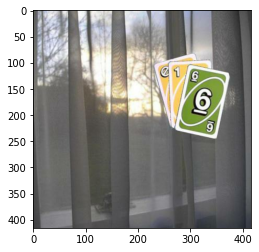

In [19]:
for image_features in parsed_image_dataset_test.take(1):
  image_raw = image_features['image/encoded']
  print(image_features['image/object/class/label'])
  plt.imshow(image_raw)

In [20]:
tf.keras.backend.clear_session()
#load detection model
detect_fn_tf_odt = tf.saved_model.load('/content/inference_graph/saved_model')

In [21]:
def load_images_into_numpy_array(id):
    image_list = []
    for image_features in parsed_image_dataset_test.take(id):
      image_list.append(image_features['image/encoded'])
      
    return image_list

def detect(image_np):
    input_tensor = np.expand_dims(image_np, 0)
    detections = detect_fn_tf_odt(input_tensor)
    return detections

In [22]:
colors = [(255,0,0),(0,255,0),(0,0,255)]

In [23]:
thrs = 0.4

def draw_prediction(imgs):
  res = []
  for img in imgs:
    detection = detect(img)
    w,h = img.shape[0],img.shape[1]
    img = cv2.UMat(img.numpy()).get()
    color_id = 0
    for i,score in enumerate(detection['detection_scores'].numpy()[0]):
      if score > thrs:
        bbx = detection['detection_boxes'].numpy()[0][i]
        detection_class = label_map[int(detection['detection_classes'].numpy()[0][i])]
        cv2.putText(img, f'{detection_class}', (int(bbx[1]*h),int(bbx[0]*w)), cv2.FONT_HERSHEY_SIMPLEX, 0.75, 
                 colors[color_id%3], 2, cv2.LINE_AA)
        cv2.rectangle(img,(int(bbx[1]*h),int(bbx[0]*w)),(int(bbx[3]*h),int(bbx[2]*w)), colors[color_id%3], 2)
       
        color_id += 1
    res.append(img)
  return res

pr = draw_prediction(load_images_into_numpy_array(16))



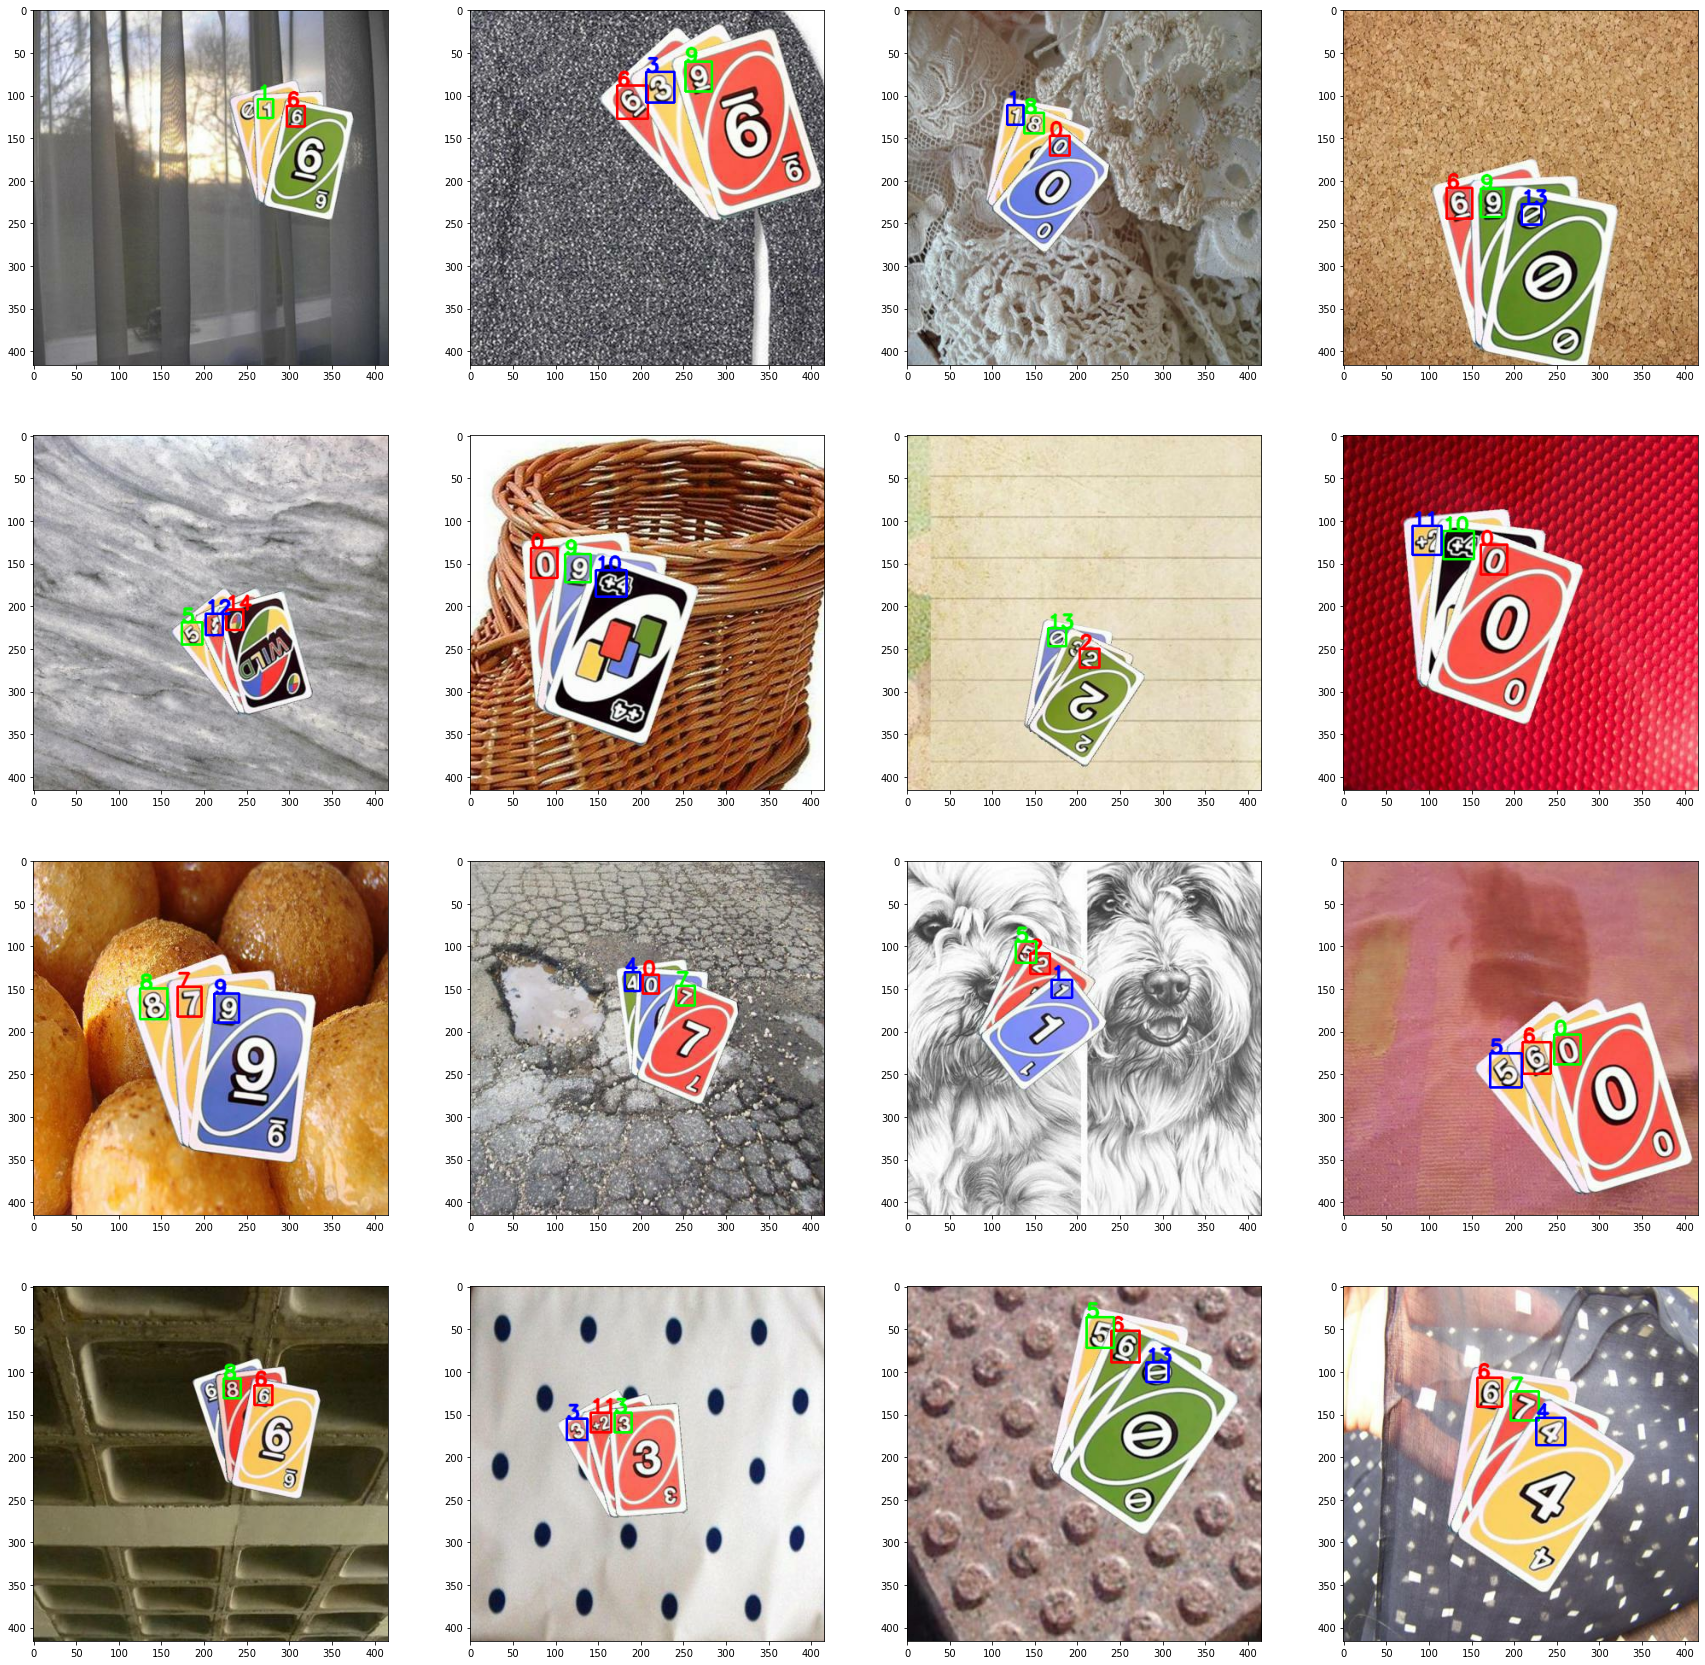

In [24]:
fig,ax = plt.subplots(4,4,figsize=(30,30))
for i,img in enumerate(pr):
  ax[i%4][i//4].imshow(pr[i])



## Real-time

In [25]:
import cv2 as cv
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import numpy as np
import PIL
import io
import html
import time
import matplotlib.pyplot as plt
from utils import JS_CODE, js_to_image, bbox_to_bytes

thrs = 0.5
def detect(image):
    img = np.expand_dims(image, 0)
    detections = detect_fn_tf_odt(img)
    return detections

In [26]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript(JS_CODE)

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data


In [ ]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break


    # convert JS response to OpenCV Image
    frame = js_to_image(js_reply["img"])
    frame = cv.cvtColor(frame,cv.COLOR_BGR2RGB)
    height_ratio,width_ratio,_ = 480,640,0 #img.shape

    # create transparent overlay for bounding box
    bbox_array = frame

    count += 1
    if True:

      # call our darknet helper on video frame
      detections = detect(frame)

      # loop through detections and draw them on transparent overlay image
      for i,score in enumerate(detections['detection_scores'].numpy()[0]):
        if score > thrs: 
          bbx = detections['detection_boxes'].numpy()[0][i]
          detection_class = label_map[int(detections['detection_classes'].numpy()[0][i])]
          cv.putText(frame, f'{detection_class}', (int(bbx[1]*width_ratio),int(bbx[0]*height_ratio)), cv2.FONT_HERSHEY_SIMPLEX, 0.75, 
                 colors[i%3], 2, cv2.LINE_AA)
      
          cv.rectangle(frame,(int(bbx[1]*width_ratio),int(bbx[0]*height_ratio)),(int(bbx[3]*width_ratio),int(bbx[2]*height_ratio)), colors[i%3], 2)

      bbox = bbox_to_bytes(bbox_array)